In [1]:
import boule as bl
import ensaio
import numpy as np
import pandas as pd
import pygmt
import verde as vd
import xarray as xr
import harmonica as hm
import scipy as scipy
from numba import njit
import matplotlib.pyplot as plt

# Load Moho & LAB and NearestNDInterpolator Function

In [2]:
# Moho                     
moho_file_path = 'moho_depth.csv'
moho_df = pd.read_csv(moho_file_path)

camlab_file_path = "D:\\Amitava\\Projects\\Perple_X\\V2RhoT_gibbs\\LAB_geoid_data\\CAM2022_lithosphere.xyz"
camlab_df = pd.read_csv(camlab_file_path, delim_whitespace=True, header=None, names=['Latitude', 'Longitude', 'Depth'])

fname = ensaio.fetch_earth_topography(version=1)
topo = xr.load_dataarray(fname)

# Topo
topo_file_path = r"D:\Amitava\Projects\Perple_X\topo\etopo2_downsampled.csv"
topo_df = pd.read_csv(topo_file_path, usecols=['x', 'y', 'z'])
topo_df.rename(columns={'x': 'Longitude', 'y': 'Latitude', 'z': 'Topo'}, inplace=True)      # Rename columns to match interpolation logic
topo_df = topo_df[['Latitude', 'Longitude', 'Topo']]  # Reorder columns

ak135_df = pd.read_csv('ak135.csv', delim_whitespace=True, usecols=['Depth(Km)', 'density(Mg/km3)'])
ak135_df.rename(columns={'Depth(Km)': 'depth', 'density(Mg/km3)': 'rho'}, inplace=True)      # Rename columns to match interpolation logic
ak135_df = ak135_df[['depth', 'rho']]  # Reorder columns

C:\Users\DELL\AppData\Local\Temp\ipykernel_2552\1638497354.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  camlab_df = pd.read_csv(camlab_file_path, delim_whitespace=True, header=None, names=['Latitude', 'Longitude', 'Depth'])
C:\Users\DELL\AppData\Local\Temp\ipykernel_2552\1638497354.py:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  ak135_df = pd.read_csv('ak135.csv', delim_whitespace=True, usecols=['Depth(Km)', 'density(Mg/km3)'])


In [3]:
moho_func = scipy.interpolate.NearestNDInterpolator(list(zip(moho_df['Latitude'], moho_df['Longitude'])), moho_df['Moho'])
camlab_func = scipy.interpolate.NearestNDInterpolator(list(zip(camlab_df['Latitude'], camlab_df['Longitude'])), camlab_df['Depth'])
topo_func = scipy.interpolate.NearestNDInterpolator(list(zip(topo_df['Latitude'], topo_df['Longitude'])), topo_df['Topo'])
rho_func = scipy.interpolate.interp1d(ak135_df['depth']*1e3,ak135_df['rho']*1e3,kind='nearest')

In [4]:
rho_func(3.4*1e3)

array(2600.)

In [5]:
#region = [west, east, south, north]
#region = [-78, -53, -57, -20] # SA
#region = [112, 155, -45, -10]  # Australia
#region = [68, 98, 6, 38]  # India
region = [-179.9, 179.9, -89.9, 89.9] # World

In [6]:
import random

# Get a random integer between 1 and 10 (inclusive)
random_integer = random.random()
print(random_integer)

0.8479601559435065


# Gravity field for different density layers

[[906781.32108003 906782.21555873 906783.74583249 ... 906781.49366732
  906781.07328951 906781.29652566]
 [908697.3128933  908736.11676764 908806.5178081  ... 908719.23832401
  908691.65795542 908696.35503016]
 [919716.72603053 920172.36105064 921036.08411102 ... 920604.80658997
  919950.83501647 919711.95437249]
 ...
 [919818.49637532 920174.59580001 920956.31723532 ... 921004.16818318
  920198.76888634 919819.01648823]
 [908593.69970672 908607.76072995 908653.67328691 ... 908665.37846175
  908613.69694426 908593.82737171]
 [906656.95946639 906657.21802571 906658.12091071 ... 906658.45174198
  906657.38546001 906656.96309319]]


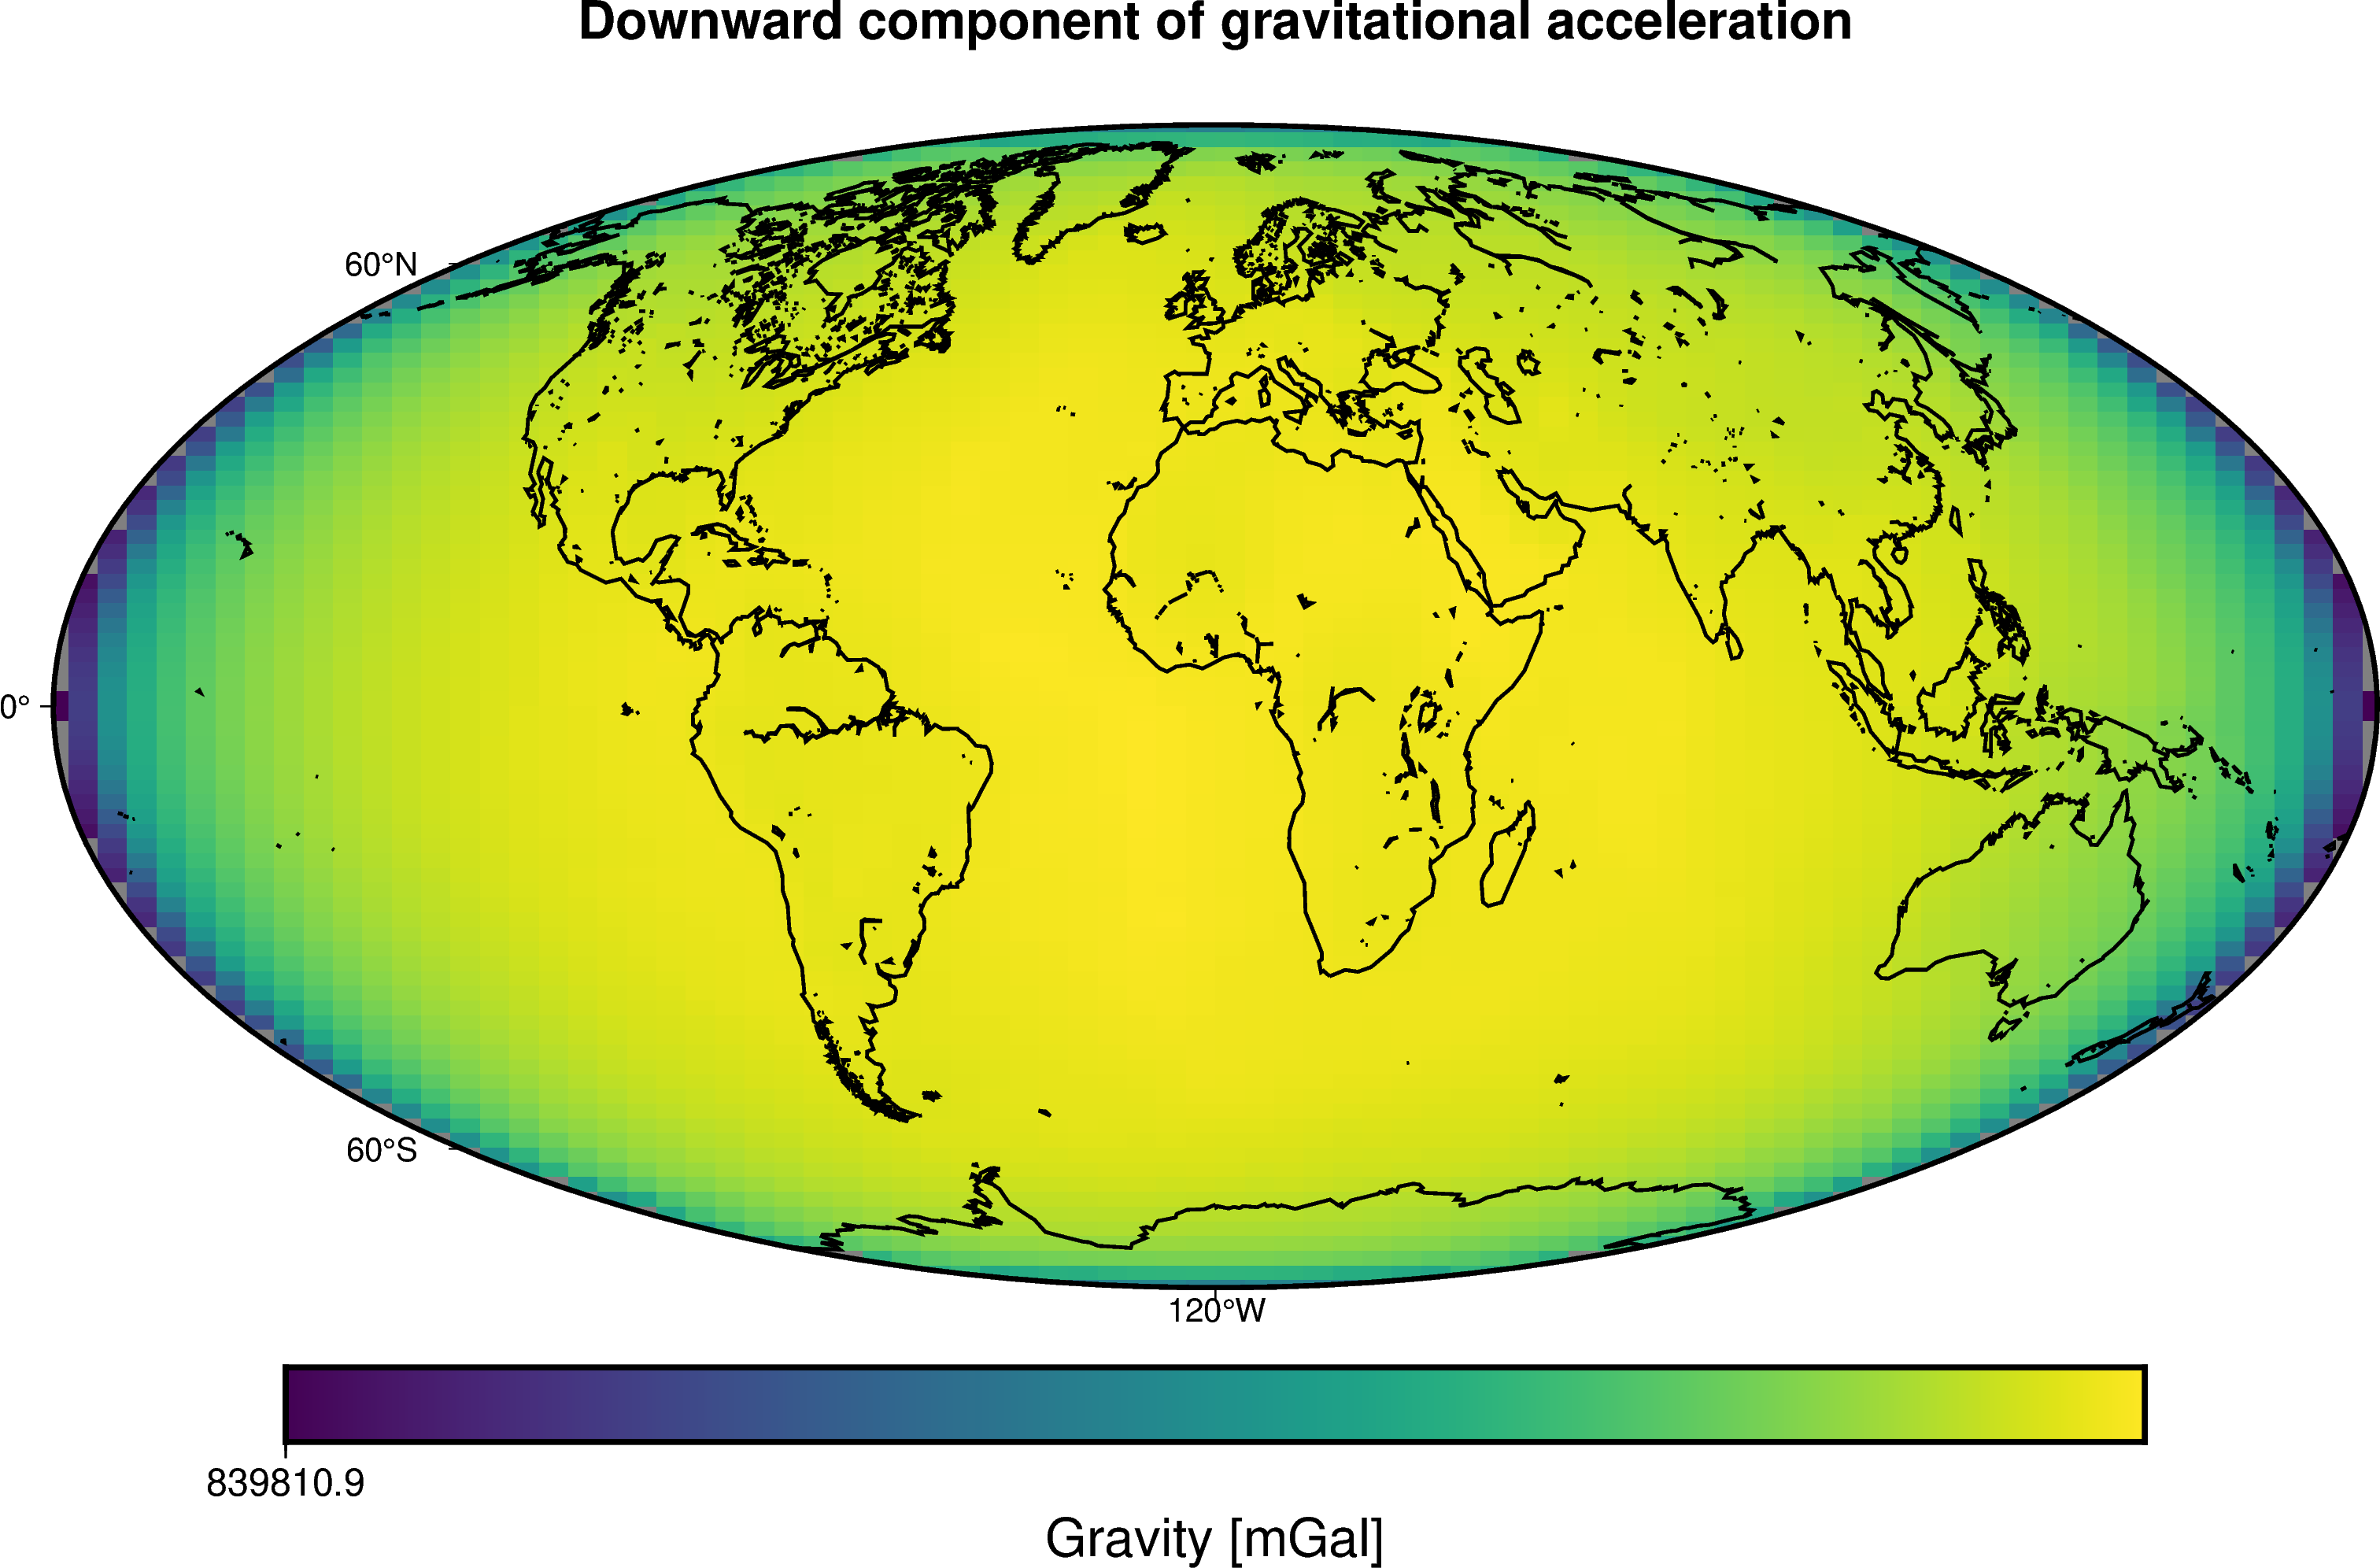

CPU times: total: 7min 29s
Wall time: 42.5 s


In [61]:
%%time
# Use the WGS84 ellipsoid to obtain the mean Earth radius
ellipsoid = bl.WGS84
mean_radius = ellipsoid.mean_radius

tesseroids = []
density = []
tess_den = []
dlong = 5
dlat = 5
longitude_max = 175
longitude_min = -175
latitude_max = 85
latitude_min = -85
depth_min = 0 #mean_radius - 400e3
#depth_max = mean_radius
ddepth = 100e3

for lat in np.arange(latitude_min, latitude_max, dlat):   
    for lon in np.arange(longitude_min, longitude_max, dlong):
        topo = topo_func(lat, lon)
        moho = moho_func(lat, lon) * 1e3
        lab = camlab_func(lat, lon) * 1e3

        r_surface = ellipsoid.geocentric_radius(latitude=lat) # in m, for radius corerction 
        depth_max = r_surface 
        # Define layer boundaries in radius from Earth's center
        layer_bounds = [r_surface - moho, r_surface - lab, r_surface - 660e3, r_surface - 2890e3, r_surface - 5150e3]
        #layer_bounds = [r_surface - moho, r_surface - lab]
        if topo < 0:
            layer_bounds.append(r_surface + topo)
        
        layer_bounds.sort() # sort in ascending order that is (r_surface - 5150e3) to (r_surface - moho) or (r_surface + topo) whichever is true

        for depth in np.arange(depth_min, depth_max, ddepth):
            #r_top_raw = r_surface - depth
            #r_bottom_raw = r_surface - min(depth + ddepth, depth_max) # min() is used in case depth + ddepth > depth_max which is beyonond the reference
            r_top_raw = min(depth + ddepth, depth_max)
            r_bottom_raw = depth

            # Check if tesseroid spans across any layer boundary
            split_layers = [b for b in layer_bounds if r_bottom_raw < b < r_top_raw]  ## b represent layer_bounds, so when b is r_bottom_raw < b < r_top_raw is false, then split_layers = []
            split_points = [r_bottom_raw] + split_layers + [r_top_raw]                ## if split_points = [r_bottom_raw] + [] + [r_top_global], then  split_points = [r_bottom_raw, r_top_global]

            for i in range(len(split_points) - 1):
                r_bottom = split_points[i]
                r_top = split_points[i + 1]
                tesseroids.append([lon, lon + dlong, lat, lat + dlat, r_bottom, r_top])

                radius_mid = 0.5 * (r_top + r_bottom)
                
                is_oceanic = topo < 0                                      # Determine if oceanic or continental column
                if r_bottom < r_surface - 5150e3:                          # Inner core
                    rho_top, rho_bottom = 12600.0, 13100.0                 # Typical PREM inner core densities                
                elif r_bottom < r_surface - 2890e3:                        # Outer core
                    rho_top, rho_bottom = 9900.0, 12100.0                  # PREM-like outer core densities                
                elif r_bottom < r_surface - 660e3:                         # Lower mantle
                    rho_top, rho_bottom = 4400.0, 5600.0                   # Lower mantle range                
                elif r_bottom < r_surface - lab:                           # Upper mantle (asthenosphere)
                #if r_bottom < r_surface - lab:
                    rho_top, rho_bottom = 3750.0, 4450.0                   # Asthenosphere densities                
                elif r_bottom < r_surface - moho:                          # Lithospheric mantle
                    rho_top, rho_bottom = 3300.0, 3700.0                   # Lithospheric mantle densities                
                elif r_bottom < mean_radius + topo:                        # Crust (oceanic or continental)
                    if is_oceanic:
                        rho_top, rho_bottom = 2850.0, 3000.0               # Oceanic crust
                    else:
                        rho_top, rho_bottom = 2700.0, 2950.0               # Continental crust                
                elif is_oceanic and r_bottom < r_surface:                  # Seawater (below sea level)
                    rho_top, rho_bottom = 1025.0, 1045.0                   # Average seawater density range                
                else:                                                      # Air or above surface
                    rho_top, rho_bottom = 0.0, 0.0                         # Ignored or handled separately

                slope = (rho_top - rho_bottom) / (r_top - r_bottom)
                density_mid = slope * (radius_mid - r_bottom) + rho_bottom
                density.append(density_mid)
                tess_den.append([lon, lon + dlong, lat, lat + dlat, r_bottom, r_top, density_mid])

   
# g'=g−ω2Rcos2λ
# where:
# g' is the effective acceleration due to gravity,
# g is the acceleration due to gravity without rotation,
# Req is the radius of the Earth at equator,
# ω is the angular velocity of the Earth, and
# λ is the latitude.
# gpoles = g−ω2Rcos290 ∘→ gpole=g  ,example
# gequator = g−ω2cos20 ∘= g−ω2R ,example
def gravity_rot(latitudes_deg):
    omega = 7.2921150e-5  # rad/s
    R_eq = ellipsoid.geocentric_radius(latitude=0)  # 6378137.0 m, WGS84 equatorial radius in meters
    phi_rad = np.radians(latitudes_deg)
    g_c = omega**2 * R_eq * np.cos(phi_rad)**2  # centrifugal accel in m/s²
    return g_c * 1e5  # convert to mGal

coordinates = vd.grid_coordinates(region=region,shape=(80, 80),extra_coords=10e3 + ellipsoid.mean_radius,) # calculated uniformly at 10 km above the WGS84 ellipsoid.

# Compute the radial component of the acceleration
#gravity = hm.tesseroid_gravity(coordinates, tesseroids, density, field="g_z")
gravity_cal = hm.tesseroid_gravity(coordinates, tesseroids, density, field="g_z")

latitudes_deg = coordinates[1] # Extract latitudes from coordinates
gravity = gravity_cal - gravity_rot(latitudes_deg) # effective gravity

print(gravity)
grid = vd.make_xarray_grid(coordinates, gravity, data_names="gravity", extra_coords_names="extra")

# Plot the gravitational field
fig = pygmt.Figure()

title = "Downward component of gravitational acceleration"

with pygmt.config(FONT_TITLE="16p"):
    fig.grdimage(region=region,projection="W25c",grid=grid.gravity,frame=["a", f"+t{title}"],cmap="viridis",)
    
vmin = float(grid.gravity.min())
vmax = float(grid.gravity.max())

fig.colorbar(cmap=True,frame=[f"x+lGravity [mGal]",f"a{vmin:.1f},{vmin:.1f},{vmax:.1f}"])
fig.coast(shorelines="1p,black")

fig.show()

In [62]:
np.shape(np.arange(latitude_min, latitude_max,dlat)),np.shape(np.arange(longitude_min, longitude_max,dlong)),np.shape(np.arange(depth_max,depth_min,-ddepth))

((34,), (70,), (64,))

In [63]:
def count_tesseroids_at_point(target_lat, target_lon, tesseroids):
    """
    Count how many tesseroids lie under a specific latitude and longitude
    using nearest-neighbor interpolation over the lat-lon grid.
    """
    grid_coords = []
    counts = {}

    for tess in tesseroids:
        lon_min, lon_max, lat_min, lat_max, *_ = tess
        key = (lat_min, lon_min)
        if key in counts:
            counts[key] += 1
        else:
            counts[key] = 1
        grid_coords.append(key)

    unique_coords = list(counts.keys())
    values = [counts[coord] for coord in unique_coords]

    interpolator = scipy.interpolate.NearestNDInterpolator(unique_coords, values)
    return int(interpolator(target_lat, target_lon))


In [64]:
lat = 7
lon = -53
print(count_tesseroids_at_point(lat, lon, tesseroids))


69


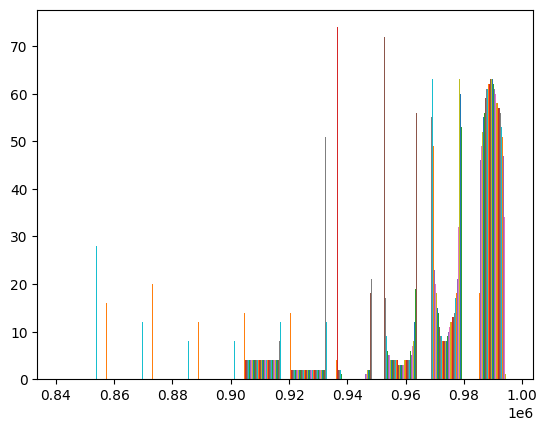

In [65]:
plt.hist(gravity);

In [66]:
print("Min gravity:", gravity.min())
print("Max gravity:", gravity.max())

Min gravity: 839810.8792220254
Max gravity: 997631.1674948233


In [67]:
gravity_=gravity.copy()

(array([5.54428084e-07, 5.44527582e-07, 5.64328585e-07, 3.96020060e-07,
        3.56418054e-06, 3.01965296e-06, 2.53452838e-06, 7.49467963e-06,
        1.38111996e-05, 3.08796642e-05]),
 array([839810.87922203, 855592.90804931, 871374.93687659, 887156.96570386,
        902938.99453114, 918721.02335842, 934503.0521857 , 950285.08101298,
        966067.10984026, 981849.13866754, 997631.16749482]),
 <BarContainer object of 10 artists>)

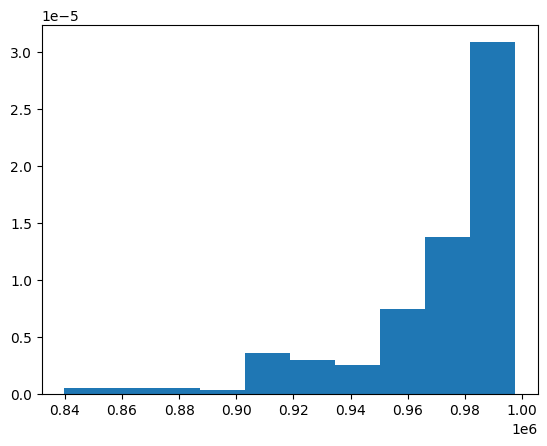

In [68]:
plt.hist(gravity_.flatten(),density=True)

In [69]:
tesseroids = np.array(tesseroids)
density = np.array(density) 
tess_den = np.array(tess_den) 

In [70]:
np.shape(tesseroids)

(165798, 6)

In [71]:
np.shape(tess_den)

(165798, 7)

In [72]:
tess_den

array([[-1.75000000e+02, -1.70000000e+02, -8.50000000e+01, ...,
         0.00000000e+00,  1.00000000e+05,  1.28500000e+04],
       [-1.75000000e+02, -1.70000000e+02, -8.50000000e+01, ...,
         1.00000000e+05,  2.00000000e+05,  1.28500000e+04],
       [-1.75000000e+02, -1.70000000e+02, -8.50000000e+01, ...,
         2.00000000e+05,  3.00000000e+05,  1.28500000e+04],
       ...,
       [ 1.70000000e+02,  1.75000000e+02,  8.00000000e+01, ...,
         6.30000000e+06,  6.34444241e+06,  3.50000000e+03],
       [ 1.70000000e+02,  1.75000000e+02,  8.00000000e+01, ...,
         6.34444241e+06,  6.35475241e+06,  2.92500000e+03],
       [ 1.70000000e+02,  1.75000000e+02,  8.00000000e+01, ...,
         6.35475241e+06,  6.35740241e+06,  2.92500000e+03]])

In [73]:
np.shape(tess_den)

(165798, 7)

In [74]:
#plt.scatter(tess_den[:, 0], tess_den[:, 2], c=tess_den[:, 6], cmap='bwr', s=5)
#plt.colorbar(label="Density (kg/m³)")

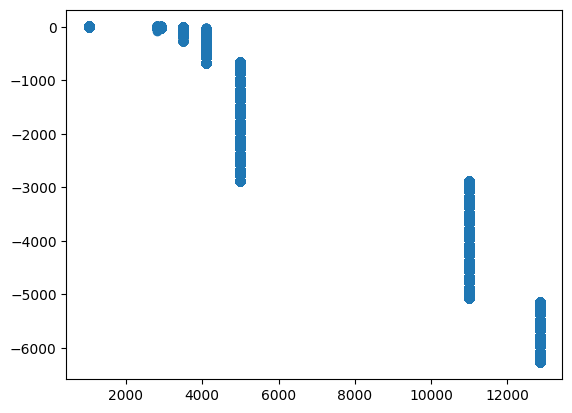

In [75]:
plt.plot(tess_den[:,6],tess_den[:,5]*1e-3-mean_radius*1e-3,'o')

6340994.401827576 6370994.401827576 -30000.0


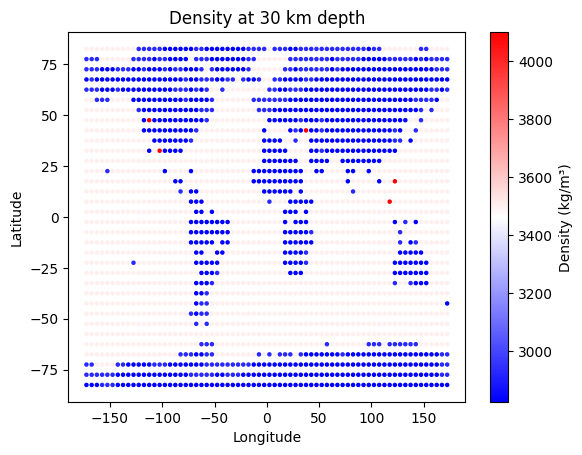

In [76]:
depth_target = 30e3  # 40 km depth
radius_target = mean_radius - depth_target
print(radius_target,mean_radius,radius_target-mean_radius)
mask = (tess_den[:, 4] <= radius_target) & (tess_den[:, 5] >= radius_target)
#mask = (tess_den[:, 4]  radius_target) #& (tess_den[:, 5] >= radius_target)

subset = tess_den[mask]
lon_center = 0.5 * (subset[:, 0] + subset[:, 1])
lat_center = 0.5 * (subset[:, 2] + subset[:, 3])
density = subset[:, 6]
plt.scatter(lon_center, lat_center, c=density, cmap='bwr', s=5) #,vmin=1e3,vmax=3.5e3)
plt.title(f"Density at {depth_target/1e3:.0f} km depth")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar(label="Density (kg/m³)")
plt.show()

6000994.401827576 6370994.401827576 -370000.0


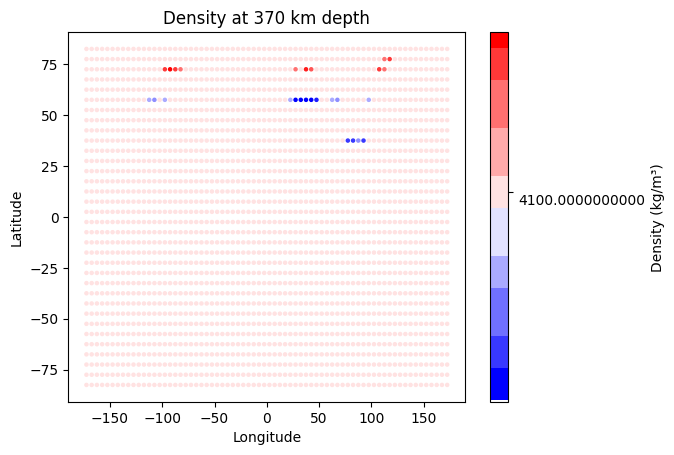

In [80]:
depth_target = 370e3  # 40 km depth
radius_target = mean_radius - depth_target
print(radius_target,mean_radius,radius_target-mean_radius)
mask = (tess_den[:, 4] < radius_target) & (tess_den[:, 5] > radius_target)

subset = tess_den[mask]
lon_center = 0.5 * (subset[:, 0] + subset[:, 1])
lat_center = 0.5 * (subset[:, 2] + subset[:, 3])
density = subset[:, 6]
plt.scatter(lon_center, lat_center, c=density, cmap='bwr', s=5) #,vmin=1e3,vmax=3.5e3)
plt.title(f"Density at {depth_target/1e3:.0f} km depth")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar(label="Density (kg/m³)")
plt.show()

In [78]:
# tess_den.([lon, lon + dlong, lat, lat + dlat, r_bottom, r_top, density_mid])
all_depths = mean_radius - tess_den[:, 4:6]
print(f"Depth range: {np.min(all_depths):.1f} m to {np.max(all_depths):.1f} m")

Depth range: -7142.6 m to 6370994.4 m


In [25]:
print("First few r_bottom values:", tess_den[:5, 4])
print("Should be ~6,000,000 (not hundreds of thousands)")

First few r_bottom values: [6256916.11430565 6312916.11430565 6156916.11430565 6247916.11430565
 6056916.11430565]
Should be ~6,000,000 (not hundreds of thousands)


In [26]:
grid

<xarray.Dataset> Size: 104kB
Dimensions:   (northing: 80, easting: 80)
Coordinates:
  * easting   (easting) float64 640B -179.9 -175.3 -170.8 ... 170.8 175.3 179.9
  * northing  (northing) float64 640B -89.9 -87.62 -85.35 ... 85.35 87.62 89.9
    extra     (northing, easting) float64 51kB 6.381e+06 6.381e+06 ... 6.381e+06
Data variables:
    gravity   (northing, easting) float64 51kB 9.068e+05 9.068e+05 ... 9.067e+05

In [27]:
# Rename dimensions and coordinates
grid_rename = grid.rename({
    "northing": "latitude",
    "easting": "longitude"
})

# Extract and rename gravity
observed_gravity = grid_rename["gravity"].rename("observed_gravity")

# Include the height/radius as a coordinate
# height = grid_rename["extra"]  # Original radius from center of Earth
lat = observed_gravity.latitude
lon = observed_gravity.longitude

# Create a 2D constant height array of 1000 m
height_2d = xr.DataArray(
    data=np.full((lat.size, lon.size), 10000.0), ## height from the reference
    coords={"latitude": lat, "longitude": lon},
    dims=("latitude", "longitude"),
    name="height"
)

# Assign 2D height as a coordinate
observed_gravity = observed_gravity.assign_coords(height=height_2d)

# Sort for CF compliance
observed_gravity = observed_gravity.sortby(["latitude", "longitude"])

# Set attributes on the data variable
observed_gravity.attrs.update({
    "units": "mGal",
    "long_name": "gravity acceleration",
    "description": "observed gravitational acceleration at Earth's surface",
    "crs": "WGS84",
    "Conventions": "CF-1.8",
    "title": "Observed gravity field",
})

# Optional: add attributes to the height coordinate
observed_gravity.coords["height"].attrs.update({
    "units": "m",
    "long_name": "height above reference ellipsoid",
    "standard_name": "height",
    "positive": "up"
})


In [28]:
observed_gravity

<xarray.DataArray 'observed_gravity' (latitude: 80, longitude: 80)> Size: 51kB
array([[906780.81848599, 906781.71182389, 906783.22990714, ...,
        906780.98587445, 906780.57339588, 906780.79392856],
       [908697.2950729 , 908736.05777876, 908806.45334592, ...,
        908719.19448268, 908691.60551093, 908696.33751921],
       [919716.64398654, 920172.87070997, 921037.16348387, ...,
        920604.25639969, 919950.45615522, 919711.84883639],
       ...,
       [919818.80390117, 920177.3117829 , 920961.94368953, ...,
        921008.92048637, 920200.85180098, 919819.31672495],
       [908593.64504344, 908607.70698201, 908653.60704466, ...,
        908665.30360947, 908613.64620132, 908593.77854315],
       [906656.4713344 , 906656.72045087, 906657.62329545, ...,
        906657.95527626, 906656.88960769, 906656.4749619 ]])
Coordinates:
  * longitude  (longitude) float64 640B -179.9 -175.3 -170.8 ... 175.3 179.9
  * latitude   (latitude) float64 640B -89.9 -87.62 -85.35 ... 85.35 87.62 89.9
    extra      (latitude, longitude) float64 51kB 6.381e+06 ... 6.381e+06
    height     (latitude, longitude) float64 51kB 1e+04 1e+04 ... 1e+04 1e+04
Attributes:
    units:        mGal
    long_name:    gravity acceleration
    description:  observed gravitational acceleration at Earth's surface
    crs:          WGS84
    Conventions:  CF-1.8
    title:        Observed gravity field

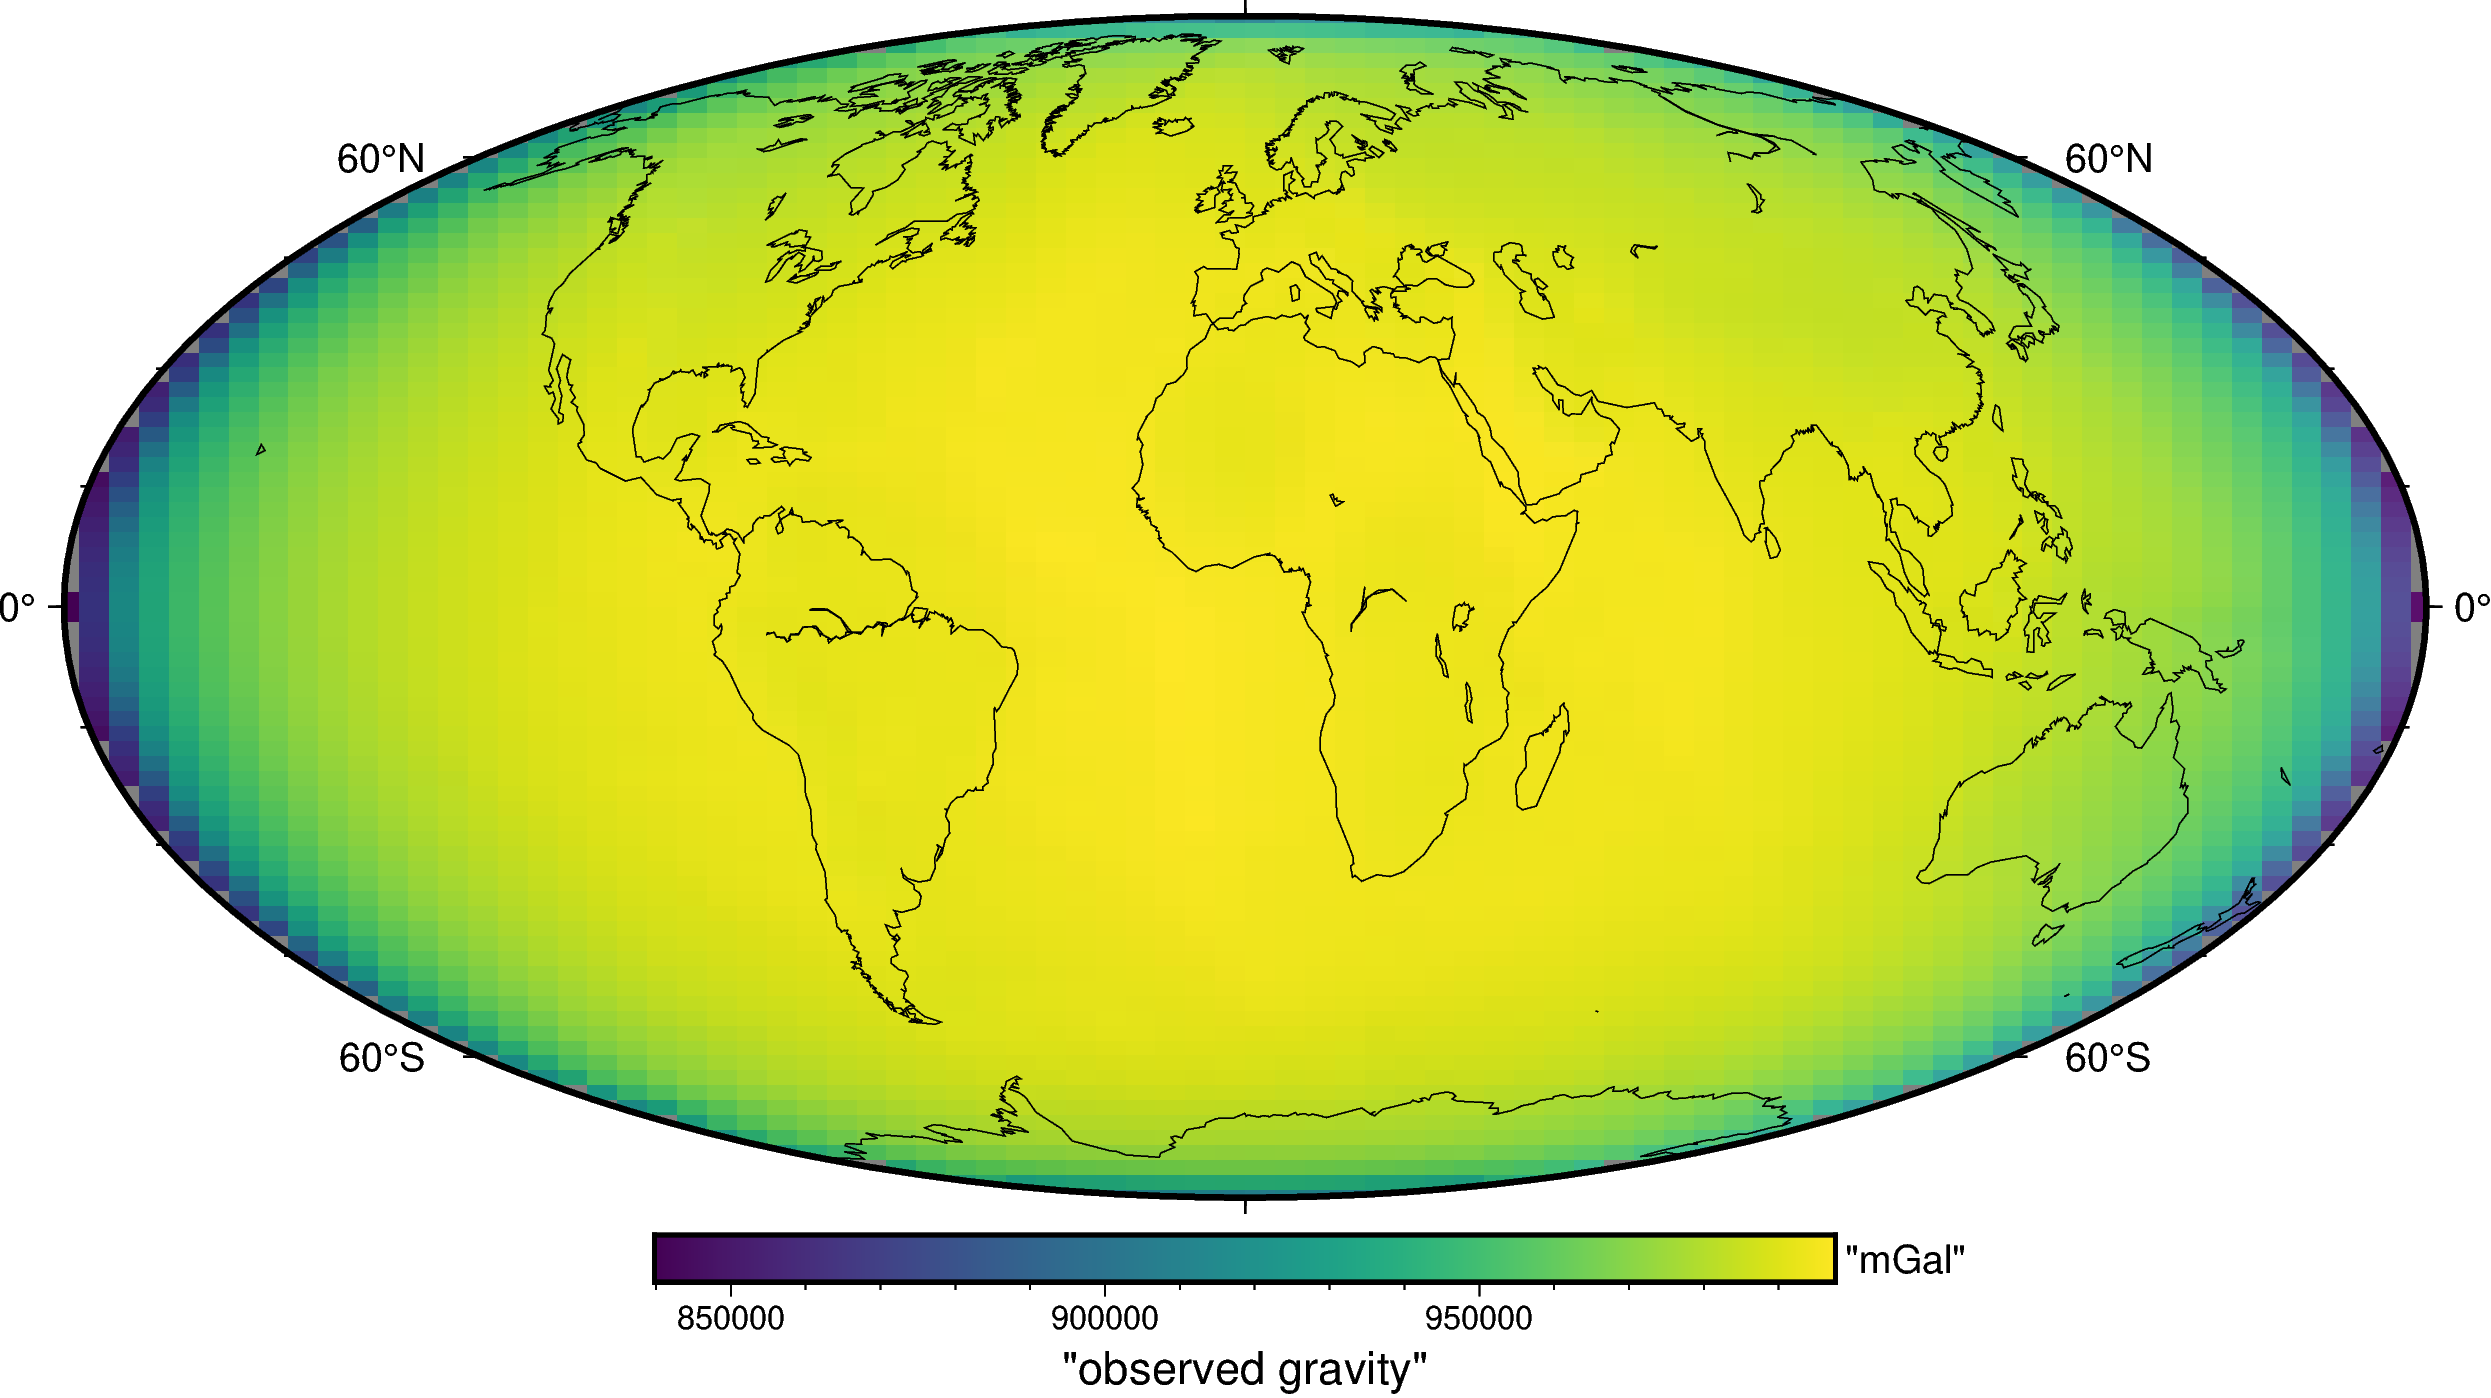

In [29]:
fig = pygmt.Figure()
fig.grdimage(
    observed_gravity,
    projection="W20c",
    cmap="viridis",
    shading="+a45+nt0.2",
)
fig.basemap(frame=["af", "WEsn"])
fig.colorbar(
    position="JCB+w10c",
    frame=["af", 'y+l"mGal"', 'x+l"observed gravity"'],
)
fig.coast(shorelines=True, resolution="c", area_thresh=1e4)
fig.show()

In [30]:
normal_gravity = ellipsoid.normal_gravity(observed_gravity.latitude, observed_gravity.height)

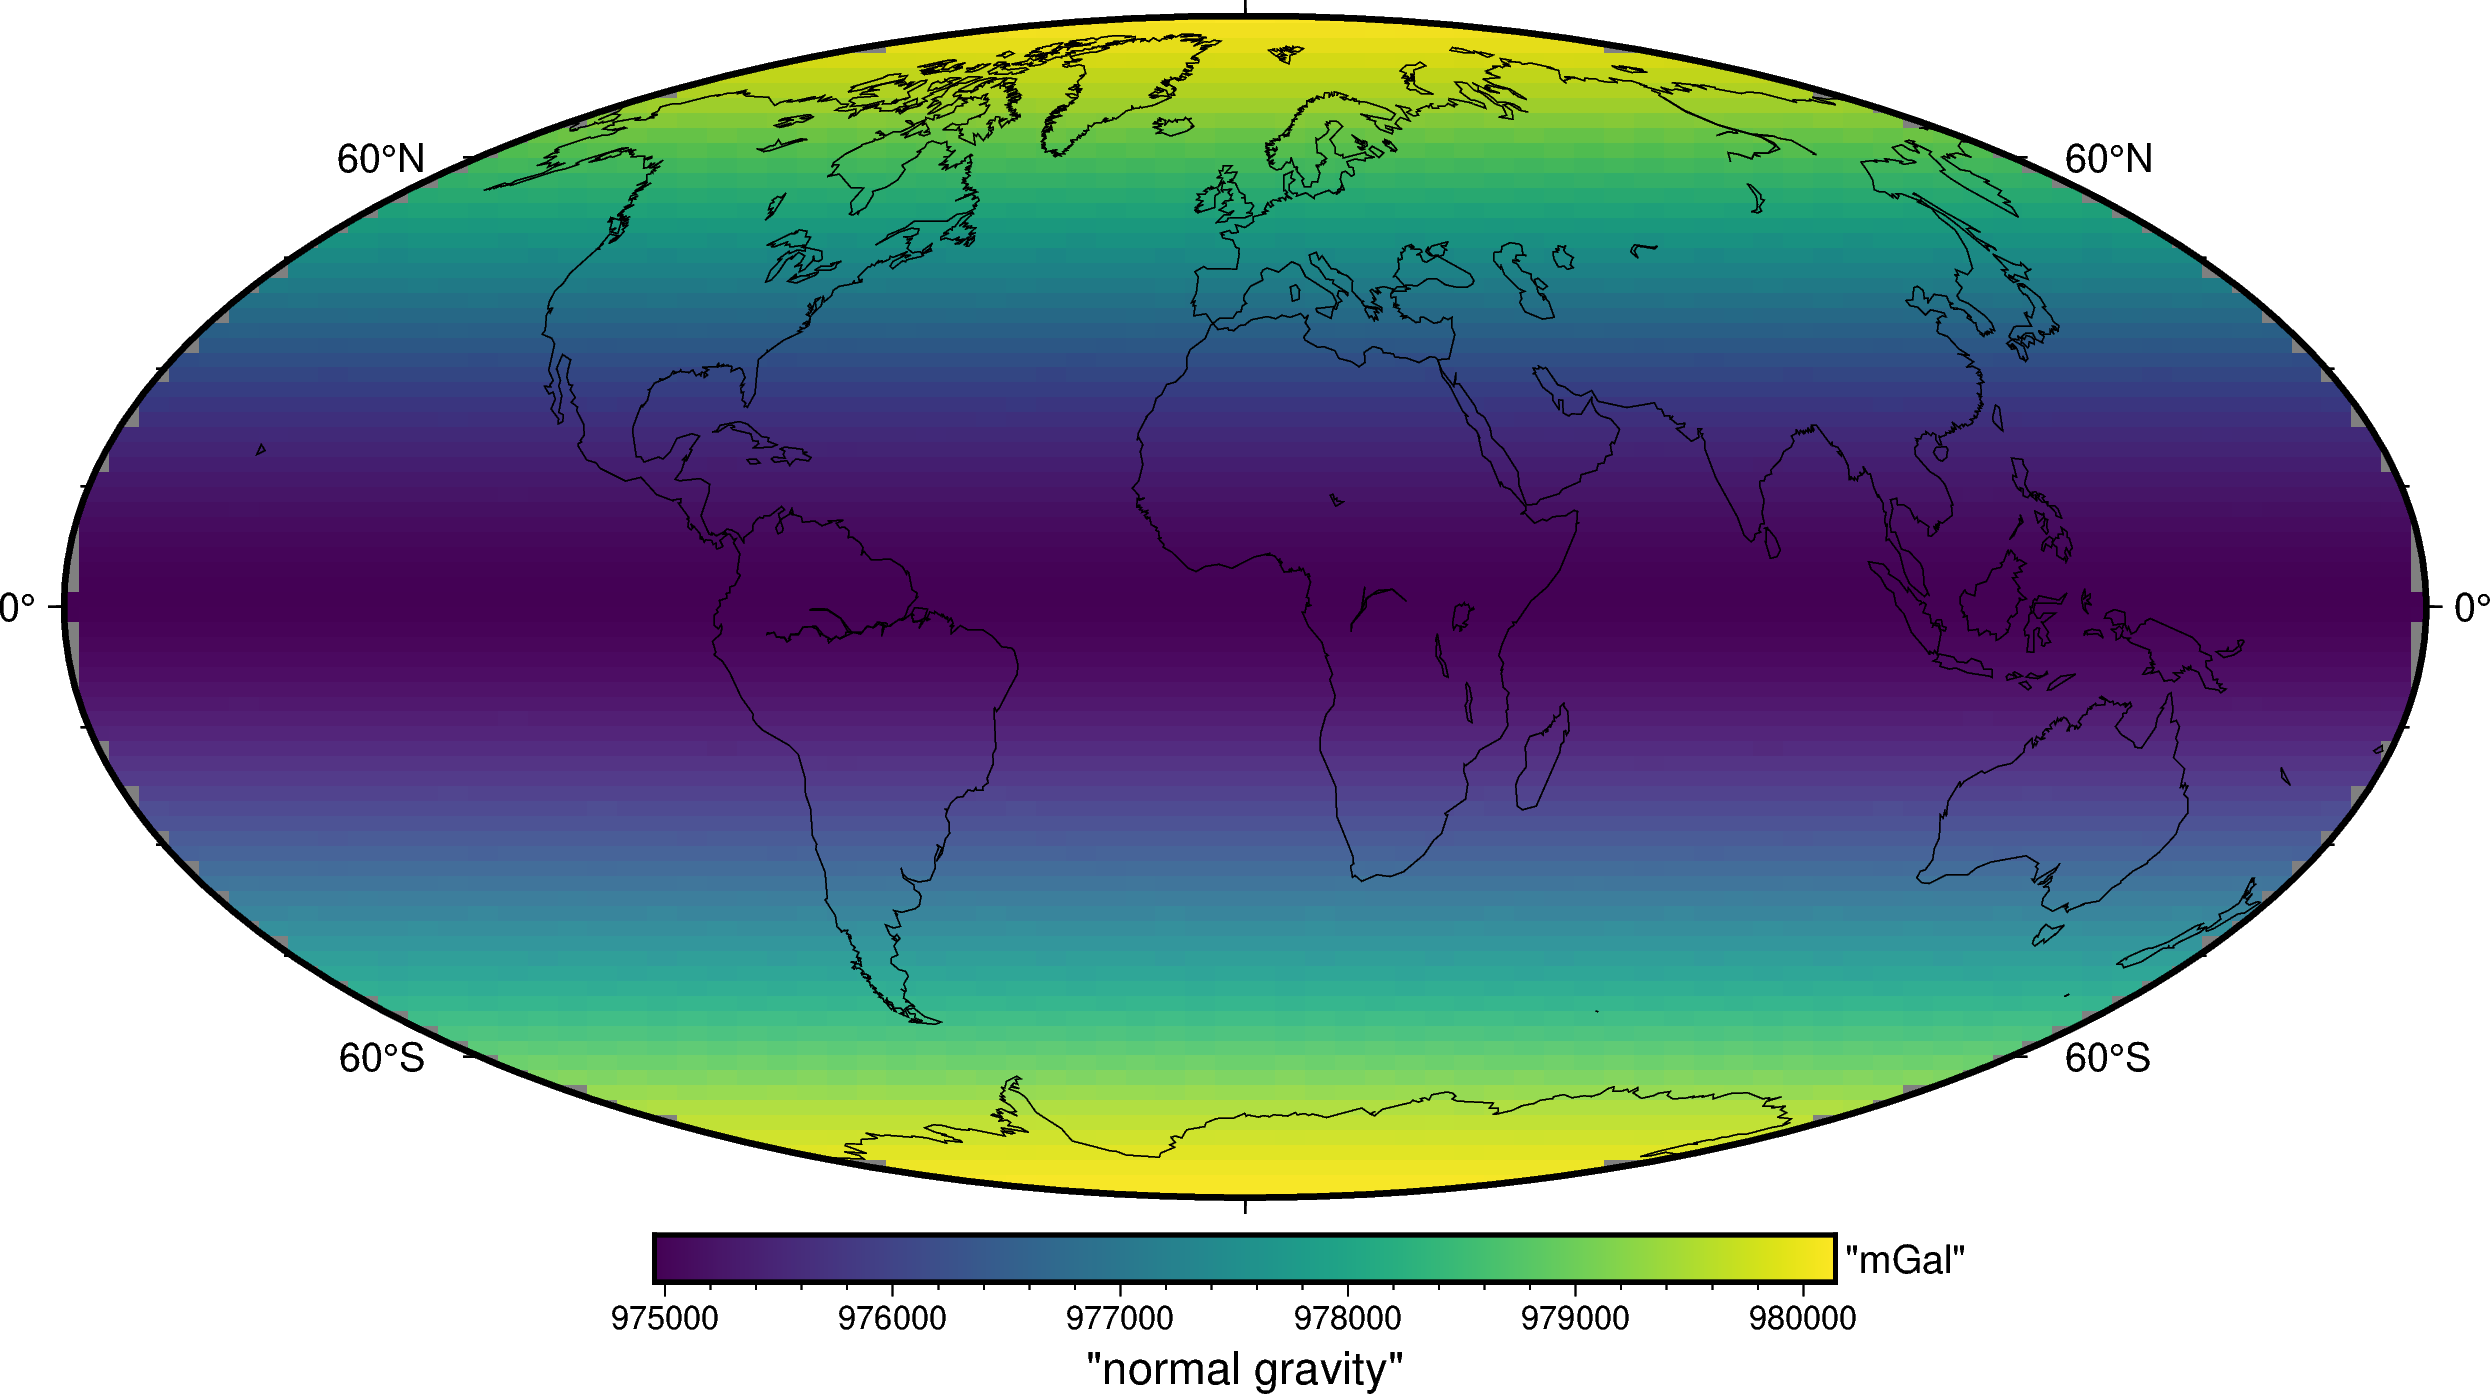

In [31]:
fig = pygmt.Figure()
fig.grdimage(
    normal_gravity,
    projection="W20c",
    cmap="viridis",
    shading="+a45+nt0.2",
)
fig.basemap(frame=["af", "WEsn"])
fig.colorbar(
    position="JCB+w10c",
    frame=["af", 'y+l"mGal"', 'x+l"normal gravity"'],
)
fig.coast(shorelines=True, resolution="c", area_thresh=1e4)
fig.show()

In [32]:
gravity_disturbance = gravity - normal_gravity
print(gravity_disturbance)

<xarray.DataArray (latitude: 80, longitude: 80)> Size: 51kB
array([[-73361.50072553, -73360.60738762, -73359.08930438, ...,
        -73361.33333707, -73361.74581564, -73361.52528296],
       [-71436.08026492, -71397.31755907, -71326.9219919 , ...,
        -71414.18085515, -71441.76982689, -71437.03781861],
       [-60391.40111738, -59935.17439395, -59070.88162005, ...,
        -59503.78870423, -60157.5889487 , -60396.19626753],
       ...,
       [-60289.24120275, -59930.73332102, -59146.10141439, ...,
        -59099.12461755, -59907.19330294, -60288.72837897],
       [-71539.73029439, -71525.66835581, -71479.76829317, ...,
        -71468.07172835, -71519.72913651, -71539.59679467],
       [-73485.84787711, -73485.59876065, -73484.69591607, ...,
        -73484.36393526, -73485.42960383, -73485.84424962]])
Coordinates:
  * latitude   (latitude) float64 640B -89.9 -87.62 -85.35 ... 85.35 87.62 89.9
  * longitude  (longitude) float64 640B -179.9 -175.3 -170.8 ... 175.3 179.9
    extra    

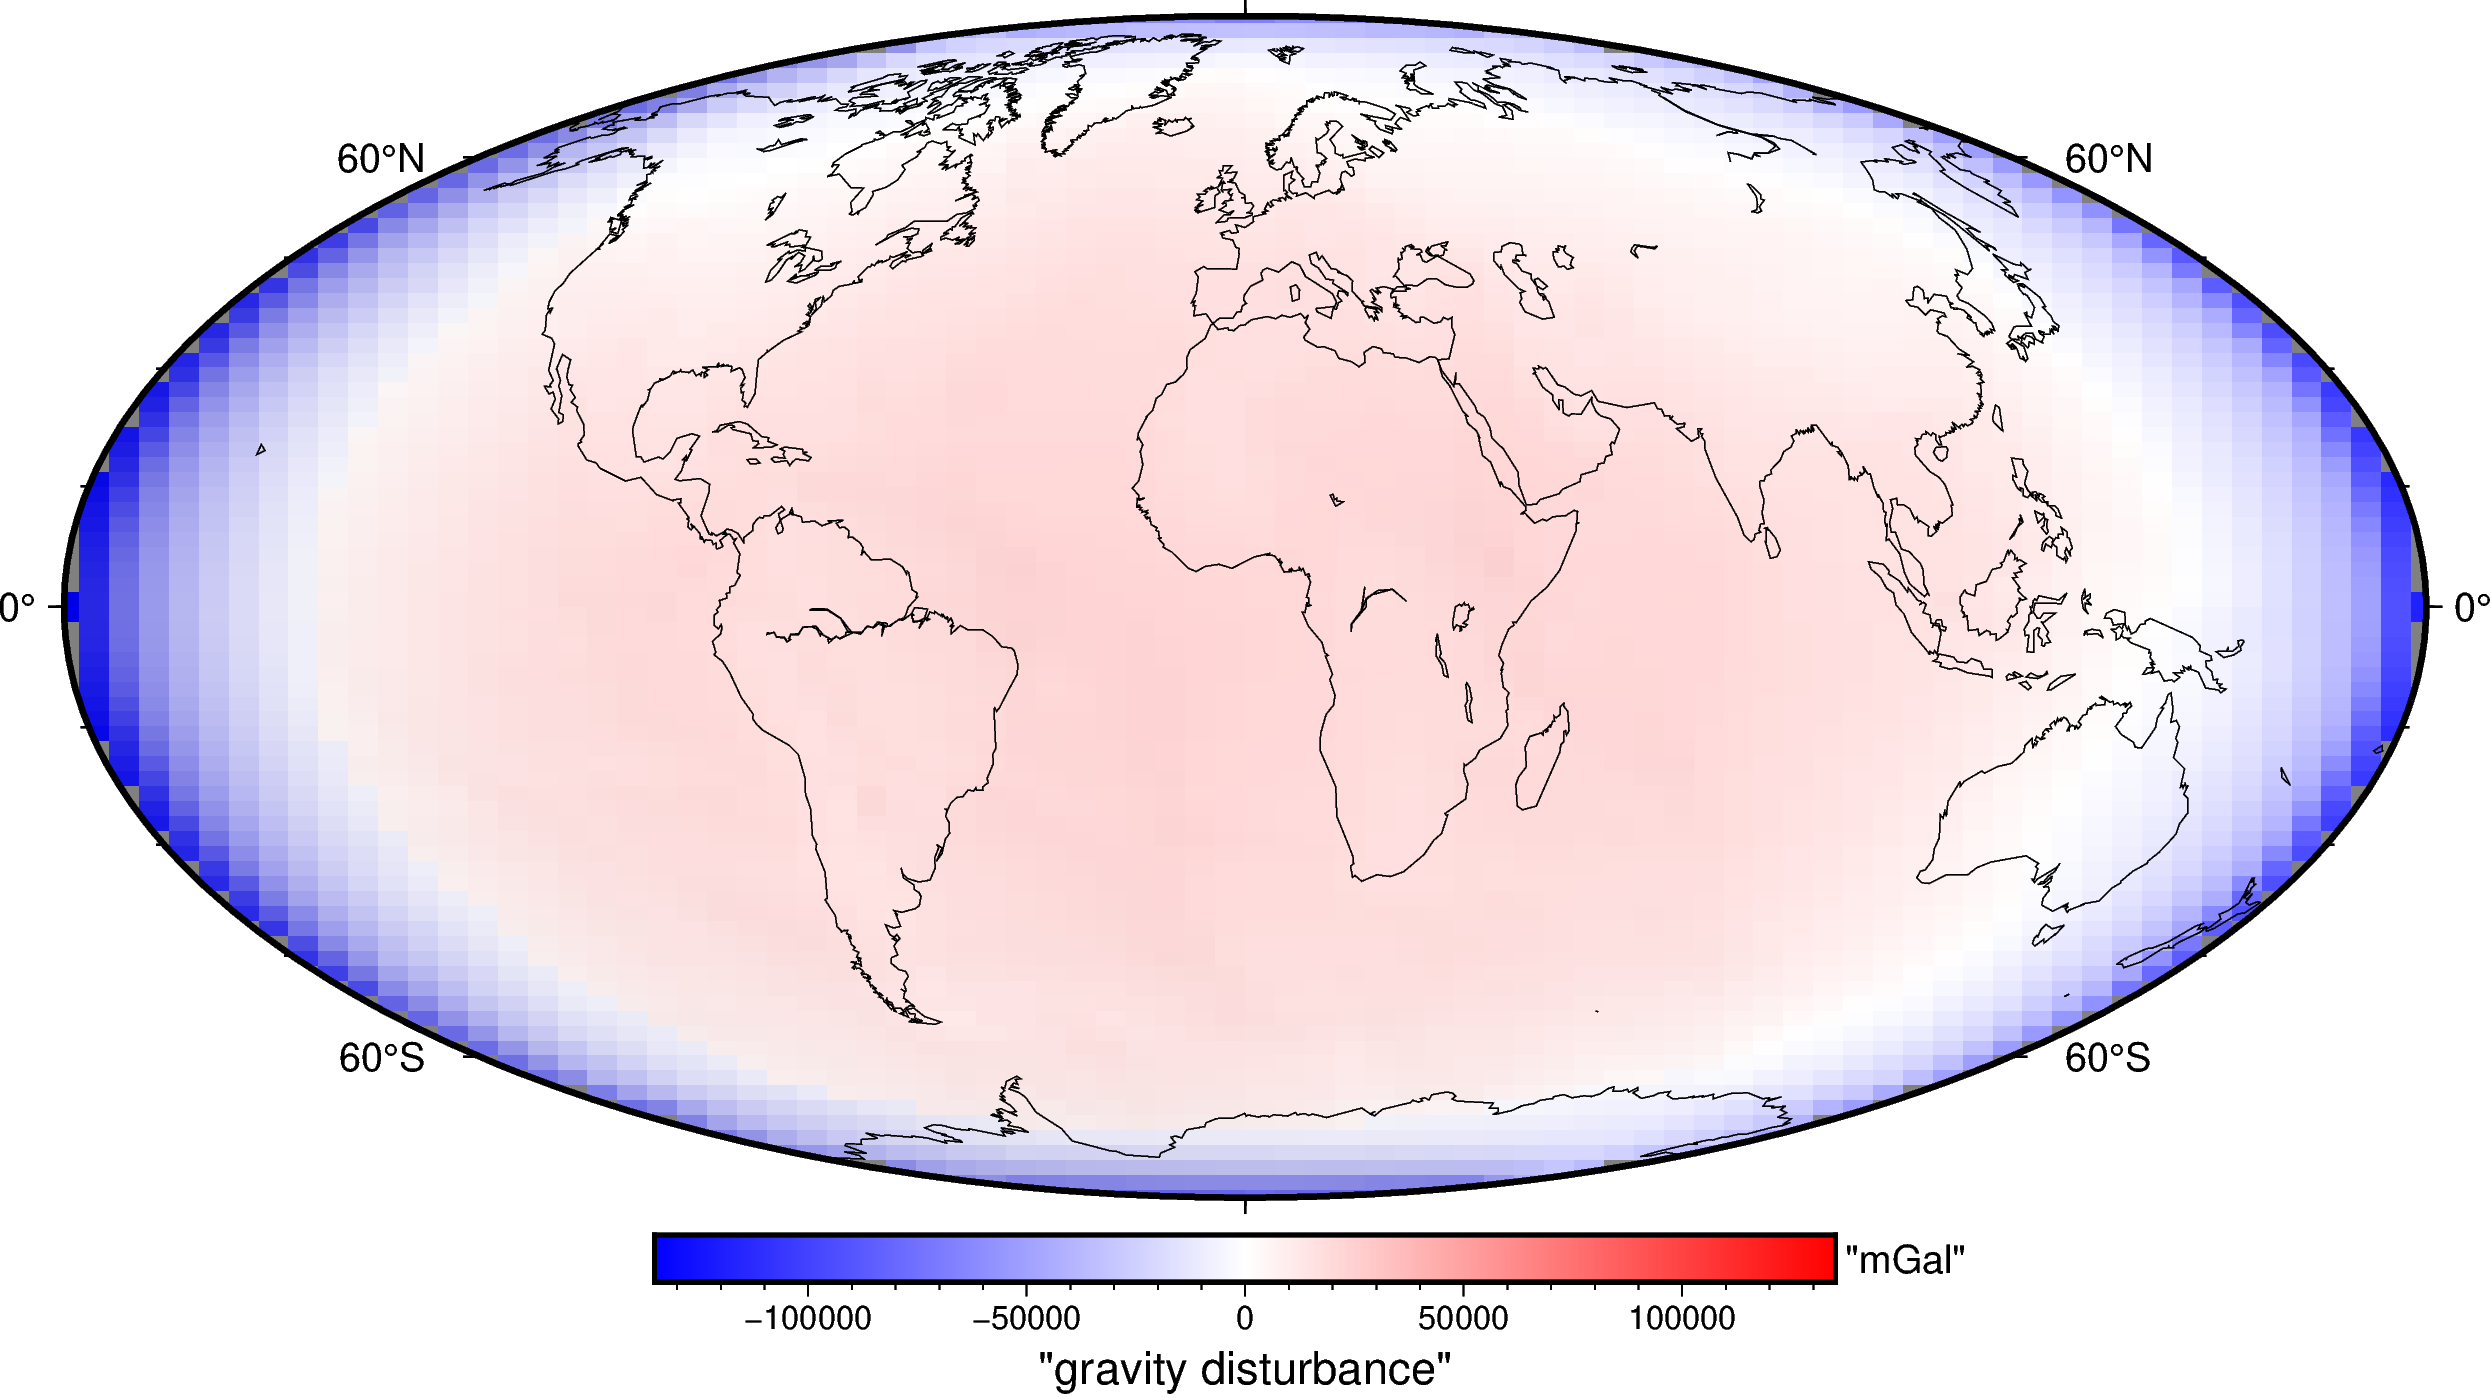

In [33]:
maxabs = vd.maxabs(gravity_disturbance)

fig = pygmt.Figure()
pygmt.makecpt(series=[-maxabs, maxabs], cmap="polar+h")
fig.grdimage(
    gravity_disturbance,
    projection="W20c",
    cmap=True,
    shading="+a45+nt0.2",
)
fig.basemap(frame=["af", "WEsn"])
fig.colorbar(
    position="JCB+w10c",
    frame=["af", 'y+l"mGal"', 'x+l"gravity disturbance"'],
)
fig.coast(shorelines=True, resolution="c", area_thresh=1e4)
fig.show()